In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [4]:
# Basic data preparation
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [5]:
# Save original date column for later use
original_dates = train['date'].copy()

# Merge with store data
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

# Merge with oil prices
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

In [6]:
# Process and merge holidays
holidays_dummies = pd.get_dummies(
    holidays, 
    columns=['type', 'locale', 'locale_name'],
    prefix=['type', 'locale', 'locale_name']
)
holidays_grouped = holidays_dummies.groupby('date').agg('sum').reset_index()
train = train.merge(holidays_grouped, on='date', how='left')
test = test.merge(holidays_grouped, on='date', how='left')

# Fill missing values
train = train.fillna(0)
test = test.fillna(0)

In [7]:
# Add basic time features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# Add cyclical features
train['month_sin'] = np.sin(2 * np.pi * train['month']/12)
train['month_cos'] = np.cos(2 * np.pi * train['month']/12)
train['day_sin'] = np.sin(2 * np.pi * train['day']/31)
train['day_cos'] = np.cos(2 * np.pi * train['day']/31)

In [8]:
# Create store and family level features
store_avg = train.groupby('store_nbr')['sales'].agg(['mean', 'std']).reset_index()
store_avg.columns = ['store_nbr', 'store_mean_sales', 'store_std_sales']

family_avg = train.groupby('family')['sales'].agg(['mean', 'std']).reset_index()
family_avg.columns = ['family', 'family_mean_sales', 'family_std_sales']

train = train.merge(store_avg, on='store_nbr', how='left')
train = train.merge(family_avg, on='family', how='left')

In [9]:
# Prepare features for modeling
feature_cols = [
    'store_nbr', 'onpromotion', 'dcoilwtico',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'store_mean_sales', 'store_std_sales',
    'family_mean_sales', 'family_std_sales',
    'day_of_week'
]

# Add holiday columns
holiday_cols = [col for col in train.columns if 'type_' in col or 'locale_' in col]
feature_cols.extend(holiday_cols)

In [10]:
# Convert categorical variables to numeric
train = pd.get_dummies(train, columns=['family', 'city', 'state', 'type'])

# Prepare final feature matrix
X = train[feature_cols]
y = train['sales']

# Create a DataFrame with dates for tracking
feature_dates = pd.DataFrame({
    'date': original_dates,
    'row_id': range(len(original_dates))
})

# Split data while preserving date information
X['row_id'] = range(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-10-c490bef06b2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['row_id'] = range(len(X))


In [11]:
# Get corresponding dates for test set
test_dates = feature_dates[feature_dates['row_id'].isin(X_test['row_id'])]['date']

# Remove row_id from features
X_train = X_train.drop('row_id', axis=1)
X_test = X_test.drop('row_id', axis=1)

scaler = StandardScaler()
num_features = [
    'store_nbr', 'onpromotion', 'dcoilwtico',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'store_mean_sales', 'store_std_sales',
    'family_mean_sales', 'family_std_sales'
]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [12]:
# Train models
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)
# rf_preds = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)
ada_preds = ada_model.predict(X_test)

# extra_model = ExtraTreesRegressor(random_state=42)
# extra_model.fit(X_train, y_train)
# extra_preds = extra_model.predict(X_test)

# ridge_model = Ridge()
# ridge_model.fit(X_train, y_train)
# ridge_preds = ridge_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 45
[LightGBM] [Info] Start training from score 357.301279


In [13]:
# Evaluate models
print("\nLGBM Results:")
lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
lgbm_mse = mean_squared_error(y_test, lgbm_preds)
lgbm_r2 = r2_score(y_test, lgbm_preds)
print(f"MAE: {lgbm_mae:.2f}")
print(f"MSE: {lgbm_mse:.2f}")
print(f"R2: {lgbm_r2:.2f}")

print("\nXGBoost Results:")
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"MAE: {xgb_mae:.2f}")
print(f"MSE: {xgb_mse:.2f}")
print(f"R2: {xgb_r2:.2f}")

# Evaluate models
print("\nLGBM Results:")
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_mse = mean_squared_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)
print(f"MAE: {gb_mae:.2f}")
print(f"MSE: {gb_mse:.2f}")
print(f"R2: {gb_r2:.2f}")

print("\nXGBoost Results:")
ada_mae = mean_absolute_error(y_test, ada_preds)
ada_mse = mean_squared_error(y_test, ada_preds)
ada_r2 = r2_score(y_test, ada_preds)
print(f"MAE: {ada_mae:.2f}")
print(f"MSE: {ada_mse:.2f}")
print(f"R2: {ada_r2:.2f}")


LGBM Results:
MAE: 105.40
MSE: 131755.95
R2: 0.89

XGBoost Results:
MAE: 99.50
MSE: 131877.36
R2: 0.89

LGBM Results:
MAE: 139.22
MSE: 201654.21
R2: 0.84

XGBoost Results:
MAE: 288.97
MSE: 448877.02
R2: 0.64


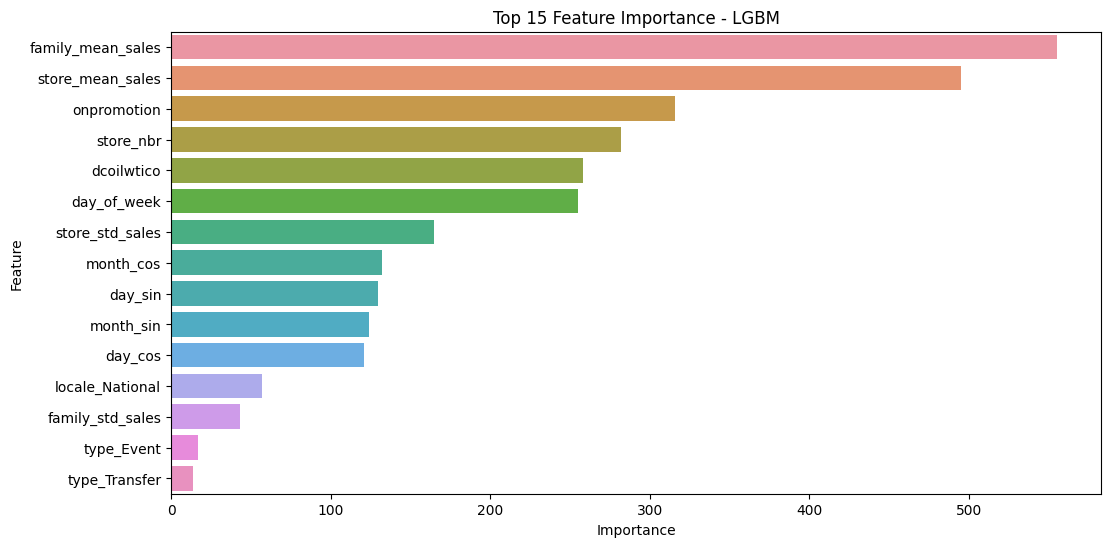

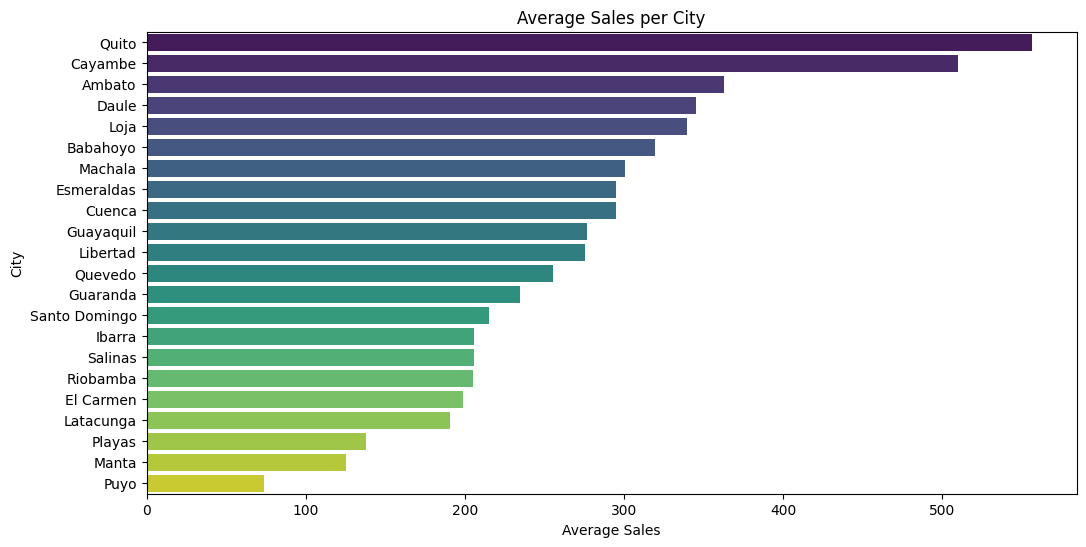

In [ ]:
# Feature Importance Plot
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_model.feature_importances_})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 15 Feature Importance - LGBM')
plt.show()

# City-wise sales analysis
train_city = train.merge(stores[['store_nbr', 'city']], on='store_nbr', how='left')
city_sales = train_city.groupby('city')['sales'].mean().reset_index().sort_values('sales', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(y='city', x='sales', data=city_sales, palette='viridis')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales per City')
plt.show()

# City-wise sales trends
city_sales_trend = train_city.groupby(['date', 'city'])['sales'].sum().reset_index()
top_cities = city_sales['city'].head(5).tolist()
plt.figure(figsize=(12, 6))
for city in top_cities:
    subset = city_sales_trend[city_sales_trend['city'] == city]
    plt.plot(subset['date'], subset['sales'], label=city)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trends Over Time for Top 5 Cities')
plt.legend()
plt.show()

In [15]:
import joblib

# Save models
joblib.dump(lgbm_model, "lgbm_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(gb_model, "gb_model.pkl")
joblib.dump(ada_model, "ada_model.pkl")

['ada_model.pkl']

In [16]:
# Load models
lgbm_model = joblib.load("lgbm_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")
gb_model = joblib.load("gb_model.pkl")
ada_model = joblib.load("ada_model.pkl")

In [17]:
# Save predictions with dates
results_df = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test,
    'lgbm_predictions': lgbm_preds,
    'gb_predictions': gb_preds,
    'ada_predictions': ada_preds,
    'xgb_predictions': xgb_preds
})

# Sort by date
results_df = results_df.sort_values('date')
results_df = results_df.groupby('date').agg({
    'actual': 'mean',  # Sum actual sales for all stores and families
    'lgbm_predictions': 'mean',
    'gb_predictions': 'mean',
    'ada_predictions': 'mean',
    'xgb_predictions': 'mean'
}).reset_index()
# Save to CSV
results_df.to_csv('model_predictions2.csv', index=False)
print("\nPredictions saved to 'model_predictions.csv'")


Predictions saved to 'model_predictions.csv'


In [19]:
# Save predictions with dates
results_df = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test,
    'lgbm_predictions': lgbm_preds,
    'gb_predictions': gb_preds,
    'ada_predictions': ada_preds,
    'xgb_predictions': xgb_preds
})

# Sort by date
results_df = results_df.sort_values('date')

# Aggregate by date (taking mean sales per day)
results_df = results_df.groupby('date').agg({
    'actual': 'mean',  # Average actual sales per day
    'lgbm_predictions': 'mean',
    'gb_predictions': 'mean',
    'ada_predictions': 'mean',
    'xgb_predictions': 'mean'
}).reset_index()

# Determine the split index for filling predictions (last 30% of the data)
split_index = int(len(results_df) * 0.7)

# Initialize predictions with NaN for the first 70%
for col in ['lgbm_predictions', 'gb_predictions', 'ada_predictions', 'xgb_predictions']:
    results_df[col] = np.where(results_df.index >= split_index, results_df[col], np.nan)

# Save to CSV
results_df.to_csv('model_predictions2.csv', index=False)

print("\nPredictions saved to 'model_predictions2.csv'")


Predictions saved to 'model_predictions2.csv'


## The Following is the full code

<ipython-input-18-739f76df1b88>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['row_id'] = range(len(X))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.443127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 45
[LightGBM] [Info] Start training from score 357.301279

LGBM Results:
MAE: 105.40
MSE: 131755.95
R2: 0.89

XGBoost Results:
MAE: 99.50
MSE: 131877.36
R2: 0.89

LGBM Results:
MAE: 139.22
MSE: 201654.21
R2: 0.84

XGBoost Results:
MAE: 288.97
MSE: 448877.02
R2: 0.64


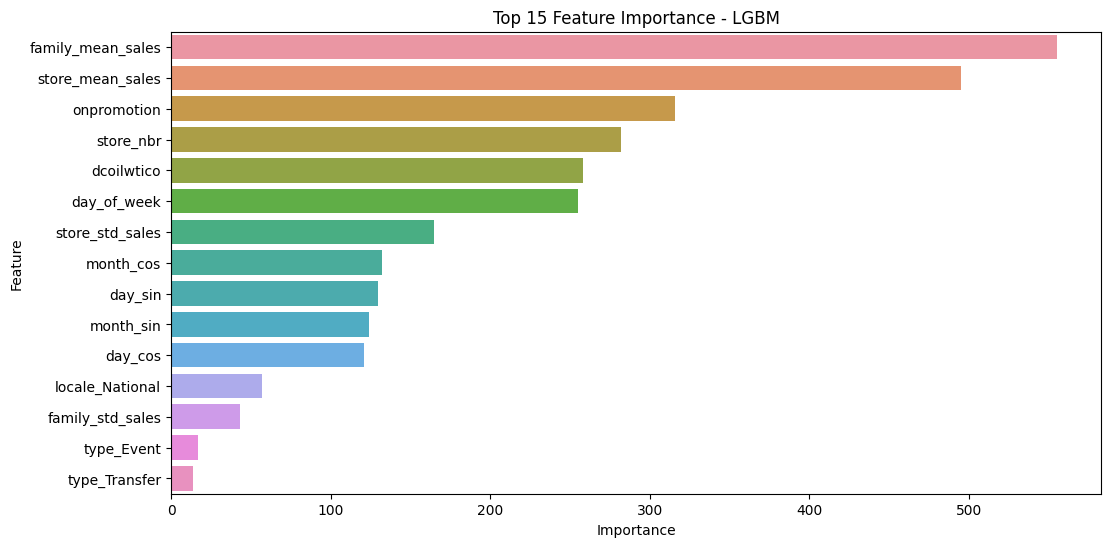

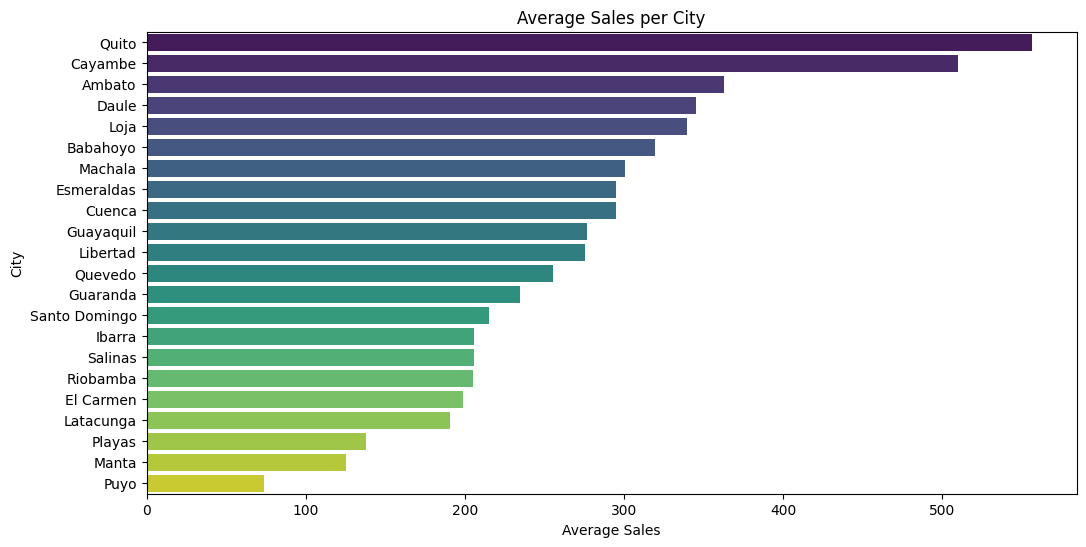

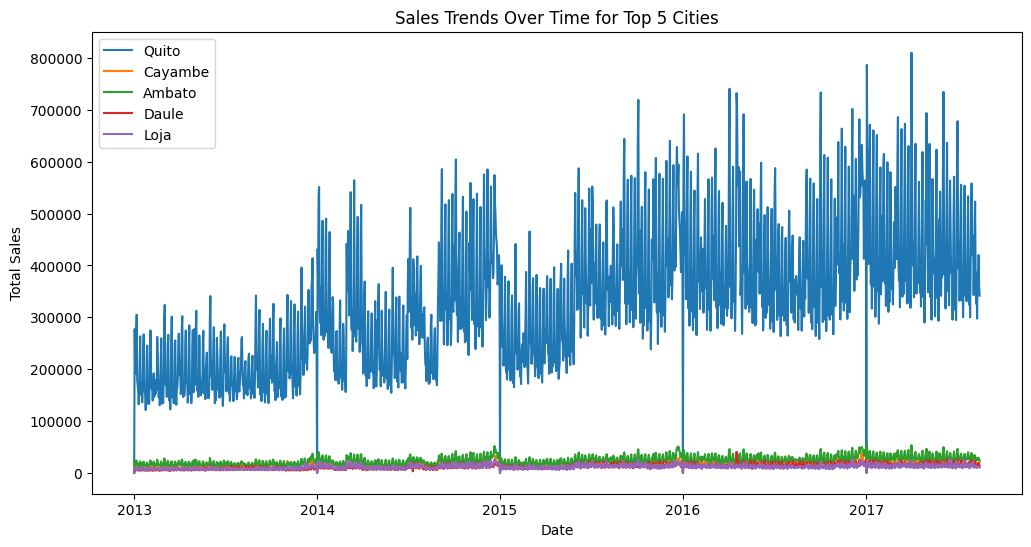


Predictions saved to 'model_predictions.csv'


['ada_model.pkl']

In [18]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

# Basic data preparation
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# Save original date column for later use
original_dates = train['date'].copy()

# Merge with store data
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

# Merge with oil prices
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

# Process and merge holidays
holidays_dummies = pd.get_dummies(
    holidays, 
    columns=['type', 'locale', 'locale_name'],
    prefix=['type', 'locale', 'locale_name']
)
holidays_grouped = holidays_dummies.groupby('date').agg('sum').reset_index()
train = train.merge(holidays_grouped, on='date', how='left')
test = test.merge(holidays_grouped, on='date', how='left')

# Fill missing values
train = train.fillna(0)
test = test.fillna(0)

# Add basic time features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# Add cyclical features
train['month_sin'] = np.sin(2 * np.pi * train['month']/12)
train['month_cos'] = np.cos(2 * np.pi * train['month']/12)
train['day_sin'] = np.sin(2 * np.pi * train['day']/31)
train['day_cos'] = np.cos(2 * np.pi * train['day']/31)


# Create store and family level features
store_avg = train.groupby('store_nbr')['sales'].agg(['mean', 'std']).reset_index()
store_avg.columns = ['store_nbr', 'store_mean_sales', 'store_std_sales']

family_avg = train.groupby('family')['sales'].agg(['mean', 'std']).reset_index()
family_avg.columns = ['family', 'family_mean_sales', 'family_std_sales']

train = train.merge(store_avg, on='store_nbr', how='left')
train = train.merge(family_avg, on='family', how='left')


# Prepare features for modeling
feature_cols = [
    'store_nbr', 'onpromotion', 'dcoilwtico',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'store_mean_sales', 'store_std_sales',
    'family_mean_sales', 'family_std_sales',
    'day_of_week'
]

# Add holiday columns
holiday_cols = [col for col in train.columns if 'type_' in col or 'locale_' in col]
feature_cols.extend(holiday_cols)

# Convert categorical variables to numeric
train = pd.get_dummies(train, columns=['family', 'city', 'state', 'type'])

# Prepare final feature matrix
X = train[feature_cols]
y = train['sales']

# Create a DataFrame with dates for tracking
feature_dates = pd.DataFrame({
    'date': original_dates,
    'row_id': range(len(original_dates))
})

# Split data while preserving date information
X['row_id'] = range(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get corresponding dates for test set
test_dates = feature_dates[feature_dates['row_id'].isin(X_test['row_id'])]['date']

# Remove row_id from features
X_train = X_train.drop('row_id', axis=1)
X_test = X_test.drop('row_id', axis=1)

scaler = StandardScaler()
num_features = [
    'store_nbr', 'onpromotion', 'dcoilwtico',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'store_mean_sales', 'store_std_sales',
    'family_mean_sales', 'family_std_sales'
]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


# Train models
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)
# rf_preds = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)
ada_preds = ada_model.predict(X_test)

# extra_model = ExtraTreesRegressor(random_state=42)
# extra_model.fit(X_train, y_train)
# extra_preds = extra_model.predict(X_test)

# ridge_model = Ridge()
# ridge_model.fit(X_train, y_train)
# ridge_preds = ridge_model.predict(X_test)

# Evaluate models
print("\nLGBM Results:")
lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
lgbm_mse = mean_squared_error(y_test, lgbm_preds)
lgbm_r2 = r2_score(y_test, lgbm_preds)
print(f"MAE: {lgbm_mae:.2f}")
print(f"MSE: {lgbm_mse:.2f}")
print(f"R2: {lgbm_r2:.2f}")

print("\nXGBoost Results:")
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"MAE: {xgb_mae:.2f}")
print(f"MSE: {xgb_mse:.2f}")
print(f"R2: {xgb_r2:.2f}")

# Evaluate models
print("\nLGBM Results:")
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_mse = mean_squared_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)
print(f"MAE: {gb_mae:.2f}")
print(f"MSE: {gb_mse:.2f}")
print(f"R2: {gb_r2:.2f}")

print("\nXGBoost Results:")
ada_mae = mean_absolute_error(y_test, ada_preds)
ada_mse = mean_squared_error(y_test, ada_preds)
ada_r2 = r2_score(y_test, ada_preds)
print(f"MAE: {ada_mae:.2f}")
print(f"MSE: {ada_mse:.2f}")
print(f"R2: {ada_r2:.2f}")

# Feature Importance Plot
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_model.feature_importances_})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 15 Feature Importance - LGBM')
plt.show()

# City-wise sales analysis
train_city = train.merge(stores[['store_nbr', 'city']], on='store_nbr', how='left')
city_sales = train_city.groupby('city')['sales'].mean().reset_index().sort_values('sales', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(y='city', x='sales', data=city_sales, palette='viridis')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales per City')
plt.show()

# City-wise sales trends
city_sales_trend = train_city.groupby(['date', 'city'])['sales'].sum().reset_index()
top_cities = city_sales['city'].head(5).tolist()
plt.figure(figsize=(12, 6))
for city in top_cities:
    subset = city_sales_trend[city_sales_trend['city'] == city]
    plt.plot(subset['date'], subset['sales'], label=city)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trends Over Time for Top 5 Cities')
plt.legend()
plt.show()

# Save predictions with dates
results_df = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test,
    'lgbm_predictions': lgbm_preds,
    'gb_predictions': gb_preds,
    'ada_predictions': ada_preds,
    'xgb_predictions': xgb_preds
})

# Sort by date
results_df = results_df.sort_values('date')
results_df = results_df.groupby('date').agg({
    'actual': 'mean',  # Sum actual sales for all stores and families
    'lgbm_predictions': 'mean',
    'gb_predictions': 'mean',
    'ada_predictions': 'mean',
    'xgb_predictions': 'mean'
}).reset_index()
# Save to CSV
results_df.to_csv('model_predictions2.csv', index=False)
print("\nPredictions saved to 'model_predictions.csv'")

import joblib

# Save models
joblib.dump(lgbm_model, "lgbm_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(gb_model, "gb_model.pkl")
joblib.dump(ada_model, "ada_model.pkl")